# Q1

In this question, we will train a simple energy-based model (EBM) on the MNIST digit dataset.

## Setup

In [ ]:
# Import necessary libraries
import random
import numpy as np
from tqdm import trange, tqdm
from matplotlib import pyplot as plt

import torch
from torch import nn, optim
import torch.nn.functional as F
from torch.utils.data import DataLoader

from torchvision import transforms
from torchvision.datasets import MNIST
from torchvision.utils import make_grid

In [ ]:
# Get cpu, gpu or mps device for training.
device = ("cuda" if torch.cuda.is_available()
          else "mps" if torch.backends.mps.is_available()
          else "cpu")
print(f"Using {device} device")

Using cuda device


# Dataset (10 points)

Load the `MNIST` dataset and normalize the images between -1 and 1 as this makes the implementation easier.

In [ ]:
class AddGaussianNoise:
    def __init__(self, std=0.03):
        self.std = std

    def __call__(self, tensor):
        return tensor + torch.randn_like(tensor) * self.std

# TODO: Define transformations and set the batch size
batch_size = 128

transform_train = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.5,), (0.5,)),
    AddGaussianNoise(std=0.03) 
])

transform_test = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.5,), (0.5,))
])

# TODO: Load train and test datasets
trainset = MNIST(root='./data', train=True, download=True, transform=transform_train)
testset = MNIST(root='./data', train=False, download=True, transform=transform_test)

# TODO: Load the train and test loaders
trainloader = DataLoader(trainset, batch_size=batch_size, shuffle=True, num_workers=0, pin_memory=True, drop_last=True)
testloader = DataLoader(testset, batch_size=batch_size, shuffle=False, num_workers=0, pin_memory=True)

# Langevin Dynamics (20 points)

The Langevin dynamics in our case starts with a randomly initialized $x_0$ and then uses the information about the landscape of the energy function
(i.e., the gradient) to seek for new $x$, that is:
$$x_{t+1} = x_{t} + \alpha \nabla_{x_t}\text{LogSumExp} \left[f_{\theta} (x) \right] + \sigma \cdot \epsilon$$

where $\alpha, \sigma > 0$ and $\epsilon \sim \mathcal{N}(0, I)$. The Langevin dynamics could be seen as the stochastic gradient descent in the observable space with a small Gaussian noise added at each step.

Our goal is to run the Langevin dynamics for $\eta$ iterations with the steps size $\alpha$ and the noise level equal $\sigma$.

In [ ]:
def energy_gradient(model, x):
    # TODO: Set model to evaluation mode
    is_training = model.training
    model.eval()

    # TDDO: Copy the original data and make it require gradients
    x_step = x.clone().detach().requires_grad_(True)

    # TODO: Calculate the gradient
    with torch.set_grad_enabled(True):
        logits = model(x_step)
        log_sum_exp = torch.logsumexp(logits, dim=1)
        grad_x = torch.autograd.grad(outputs=log_sum_exp.sum(), inputs=x_step)[0]

    # TODO: Set model to training mode
    model.train(is_training)

    # TODO: Return the gradients
    return grad_x

In [ ]:
def langevin_dynamics_step(model, x, alpha, sigma):
    # TODO: Calculate gradient w.r.t. x
    grad_x = energy_gradient(model, x)

    # TODO: Sample epsilon ~ Normal(0, I)
    epsilon = torch.randn_like(x)

    # TODO: Generate a new sample
    x_new = x + (alpha * grad_x) + (sigma * epsilon)
    
    # Restrict to valid normalized image range, slightly inset to avoid edge-case dead gradients
    x_new = torch.clamp(x_new, min=-0.999, max=0.999)

    # TODO: Return the new sample
    return x_new.detach()

# Sampling (15 points)

In [ ]:
def sample(model, eta, alpha, sigma, num_samples=16, anneal_noise=False):
    device = next(model.parameters()).device
    
    # TODO: Sample x0 from uniform [-1, +1]
    x = torch.rand((num_samples, 1, 28, 28), device=device) * 2.0 - 1.0

    # TODO: Run Langevin Dynamics η times
    for t in range(eta):
        if anneal_noise:
            decay_factor = 1.0 - (t / max(1, eta - 1))
            current_sigma = sigma * (0.25 + 0.75 * decay_factor)
        else:
            current_sigma = sigma
            
        x = langevin_dynamics_step(model, x, alpha, current_sigma)

    # TODO: Return the result
    return x

# Loss (15 points)

We can evaluate our model using the following objective:

$$\mathcal{L} = \mathcal{L}_\text{clf}(\theta) + \mathcal{L}_\text{gen}(\theta)$$

Where $\mathcal{L}_\text{clf}(\theta)$ is the cross-entropy loss and $\mathcal{L}_\text{gen}(\theta)$ is an approximation to the log-marginal distribution over images (for example the LogSumExp loss).

In [ ]:
def loss_function(model, eta, alpha, sigma, x, y_pred, y_true):
    # TODO: Calculate the discriminative loss: the cross-entropy
    loss_clf = F.cross_entropy(y_pred, y_true)

    # TODO: Calculate the generative loss: E(x) - E(x_sample)
    energy_real = -torch.logsumexp(y_pred, dim=1)
    
    x_fake = torch.rand_like(x) * 2.0 - 1.0
    for _ in range(eta):
        x_fake = langevin_dynamics_step(model, x_fake, alpha, sigma)
        
    y_fake = model(x_fake)
    energy_fake = -torch.logsumexp(y_fake, dim=1)
    
    loss_gen = (energy_real - energy_fake).mean()

    # TODO: Return the total loss
    return loss_clf + loss_gen

# Neural Network (10 points)

Define the neural network that specifies the energy function.
The inputs should be images and the outputs must be the classes.
Don't forget to use appropriate activation functions!

In [ ]:
class EnergyNet(nn.Module):
    def __init__(self):
        super().__init__()
        self.net = nn.Sequential(
            nn.Flatten(),
            nn.Linear(28 * 28, 512),
            nn.SiLU(inplace=True),
            nn.Linear(512, 512),
            nn.SiLU(inplace=True),
            nn.Linear(512, 512),
            nn.SiLU(inplace=True),
            nn.Linear(512, 10)
        )

    def forward(self, x, y=None):
        return self.net(x)

# Visualize (15 points)

Create the following functions to be able to visualize real and generated images.

In [ ]:
def visualize_real(loader):
    x, y = next(iter(loader))
    x = x[:16]
    x = (x * 0.5) + 0.5
    
    grid = make_grid(x, nrow=4, padding=2, normalize=False)
    
    plt.figure(figsize=(5, 5))
    plt.imshow(grid.permute(1, 2, 0).cpu().numpy())
    plt.title("Real MNIST Samples")
    plt.axis("off")
    plt.show()

def visualize_generated(model, eta, alpha, sigma, loader=None):
    model.eval()
    
    print(f"Generating samples using η={eta}... (this may take a moment)")
    samples = sample(model, eta, alpha, sigma, num_samples=16, anneal_noise=True)
    
    samples = (samples * 0.5) + 0.5
    
    grid = make_grid(samples, nrow=4, padding=2, normalize=False)
    
    plt.figure(figsize=(5, 5))
    plt.imshow(grid.permute(1, 2, 0).cpu().numpy())
    plt.title(f"Generated Samples")
    plt.axis("off")
    plt.show()
    
    model.train()

# Training (15 points)

Fill in the evaluation and training functions. Make sure you track the loss and plot it to analyze possible issues.

In [ ]:
def eval_ebm(model, loader, eta, alpha, sigma):
    # TODO: Evaluate the model on the loader
    model.eval()
    total_loss = 0.0
    correct = 0
    total = 0
    
    with torch.no_grad():
        # Only evaluating on a few batches to speed up the validation phase
        for i, (x, y) in enumerate(loader):
            if i > 5: break 
            
            x, y = x.to(device), y.to(device)
            y_pred = model(x)
            
            preds = torch.argmax(y_pred, dim=1)
            correct += (preds == y).sum().item()
            total += y.size(0)
            
            batch_loss = loss_function(model, eta, alpha, sigma, x, y_pred, y)
            total_loss += batch_loss.item()
            
    avg_loss = total_loss / 6.0 
    accuracy = correct / total
    return avg_loss, accuracy

def train_ebm(model, optimizer, loader, epochs, eta, alpha, sigma, scheduler=None):
    # TODO: Train the model on the loader
    history = {'train_loss': []}
    
    for epoch in range(epochs):
        model.train()
        epoch_loss = 0.0
        
        pbar = tqdm(loader, desc=f"Epoch {epoch+1}/{epochs}")
        
        for x, y in pbar:
            x, y = x.to(device), y.to(device)
            
            optimizer.zero_grad()
            y_pred = model(x)
            
            loss = loss_function(model, eta, alpha, sigma, x, y_pred, y)
            loss.backward()
            
            torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=1.0)
            optimizer.step()
            
            epoch_loss += loss.item()
            pbar.set_postfix({'loss': f"{loss.item():.4f}"})
            
        if scheduler:
            scheduler.step()
            
        avg_train_loss = epoch_loss / len(loader)
        history['train_loss'].append(avg_train_loss)
        
        val_loss, val_acc = eval_ebm(model, testloader, eta, alpha, sigma)
        print(f"Epoch {epoch+1} | Train Loss: {avg_train_loss:.4f} | Val Loss: {val_loss:.4f} | Val Acc: {val_acc*100:.2f}%")
        
    return history

Now define the optimizer and train your model.

In [ ]:
# TODO: Train your EBM
ETA = 50          
ALPHA = 0.75      
SIGMA = 0.08      
EPOCHS = 30       

ebm_model = EnergyNet().to(device)

optimizer = optim.Adamax(ebm_model.parameters(), lr=1e-3)
scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=3, gamma=0.5)

print("Starting EBM Training...")
train_history = train_ebm(
    model=ebm_model, 
    optimizer=optimizer, 
    loader=trainloader, 
    epochs=EPOCHS, 
    eta=ETA, 
    alpha=ALPHA, 
    sigma=SIGMA,
    scheduler=scheduler
)

Starting EBM Training...


Epoch 1/30: 100%|██████████| 468/468 [00:20<00:00, 22.54it/s, loss=0.0157] 


Epoch 1 | Train Loss: 0.9221 | Val Loss: 1.0601 | Val Acc: 75.39%


Epoch 2/30: 100%|██████████| 468/468 [00:21<00:00, 21.77it/s, loss=0.2106] 


Epoch 2 | Train Loss: 0.6200 | Val Loss: 0.8723 | Val Acc: 83.72%


Epoch 3/30: 100%|██████████| 468/468 [00:21<00:00, 21.73it/s, loss=0.5348] 


Epoch 3 | Train Loss: 0.5448 | Val Loss: -0.8651 | Val Acc: 86.98%


Epoch 4/30: 100%|██████████| 468/468 [00:21<00:00, 22.10it/s, loss=-0.2521]


Epoch 4 | Train Loss: 0.3016 | Val Loss: -0.5546 | Val Acc: 87.24%


Epoch 5/30: 100%|██████████| 468/468 [00:21<00:00, 22.19it/s, loss=0.2613] 


Epoch 5 | Train Loss: 0.3494 | Val Loss: -0.8718 | Val Acc: 90.23%


Epoch 6/30: 100%|██████████| 468/468 [00:21<00:00, 21.39it/s, loss=-1.7246]


Epoch 6 | Train Loss: 0.3405 | Val Loss: -1.6188 | Val Acc: 90.10%


Epoch 7/30: 100%|██████████| 468/468 [00:23<00:00, 20.32it/s, loss=0.8506] 


Epoch 7 | Train Loss: 0.1943 | Val Loss: 0.1217 | Val Acc: 88.54%


Epoch 8/30: 100%|██████████| 468/468 [00:23<00:00, 19.70it/s, loss=-1.0577]


Epoch 8 | Train Loss: 0.2141 | Val Loss: -0.0416 | Val Acc: 89.19%


Epoch 9/30: 100%|██████████| 468/468 [00:22<00:00, 20.87it/s, loss=-0.8230]


Epoch 9 | Train Loss: 0.1861 | Val Loss: -0.0336 | Val Acc: 90.49%


Epoch 10/30: 100%|██████████| 468/468 [00:21<00:00, 22.00it/s, loss=-1.7445]


Epoch 10 | Train Loss: 0.1138 | Val Loss: -0.3387 | Val Acc: 92.19%


Epoch 11/30: 100%|██████████| 468/468 [00:23<00:00, 20.25it/s, loss=1.2510] 


Epoch 11 | Train Loss: 0.1290 | Val Loss: -0.1952 | Val Acc: 91.02%


Epoch 12/30: 100%|██████████| 468/468 [00:21<00:00, 21.67it/s, loss=1.3172] 


Epoch 12 | Train Loss: 0.1180 | Val Loss: -0.3625 | Val Acc: 91.41%


Epoch 13/30: 100%|██████████| 468/468 [00:22<00:00, 21.18it/s, loss=0.1836] 


Epoch 13 | Train Loss: 0.0479 | Val Loss: -1.1372 | Val Acc: 92.06%


Epoch 14/30: 100%|██████████| 468/468 [00:21<00:00, 21.40it/s, loss=-1.4612]


Epoch 14 | Train Loss: 0.0635 | Val Loss: 0.5228 | Val Acc: 91.80%


Epoch 15/30: 100%|██████████| 468/468 [00:22<00:00, 20.46it/s, loss=1.2916] 


Epoch 15 | Train Loss: 0.0863 | Val Loss: -0.2063 | Val Acc: 91.54%


Epoch 16/30: 100%|██████████| 468/468 [00:22<00:00, 20.73it/s, loss=-0.4514]


Epoch 16 | Train Loss: 0.0153 | Val Loss: 0.0449 | Val Acc: 91.28%


Epoch 17/30: 100%|██████████| 468/468 [00:22<00:00, 21.24it/s, loss=0.7109] 


Epoch 17 | Train Loss: 0.0351 | Val Loss: 0.0044 | Val Acc: 91.80%


Epoch 18/30: 100%|██████████| 468/468 [00:22<00:00, 21.17it/s, loss=1.7155] 


Epoch 18 | Train Loss: -0.0084 | Val Loss: -0.2232 | Val Acc: 91.80%


Epoch 19/30: 100%|██████████| 468/468 [00:21<00:00, 21.68it/s, loss=-0.3073]


Epoch 19 | Train Loss: -0.0028 | Val Loss: 0.1053 | Val Acc: 91.41%


Epoch 20/30: 100%|██████████| 468/468 [00:22<00:00, 21.07it/s, loss=1.4081] 


Epoch 20 | Train Loss: -0.0036 | Val Loss: 0.0835 | Val Acc: 91.54%


Epoch 21/30: 100%|██████████| 468/468 [00:21<00:00, 22.13it/s, loss=-0.0744]


Epoch 21 | Train Loss: -0.0318 | Val Loss: -0.6615 | Val Acc: 91.41%


Epoch 22/30: 100%|██████████| 468/468 [00:22<00:00, 21.26it/s, loss=0.2414] 


Epoch 22 | Train Loss: 0.0036 | Val Loss: -0.6163 | Val Acc: 92.19%


Epoch 23/30: 100%|██████████| 468/468 [00:21<00:00, 21.77it/s, loss=-1.5852]


Epoch 23 | Train Loss: -0.0559 | Val Loss: -0.8761 | Val Acc: 91.80%


Epoch 24/30: 100%|██████████| 468/468 [00:21<00:00, 21.49it/s, loss=-0.3156]


Epoch 24 | Train Loss: -0.0586 | Val Loss: 0.4267 | Val Acc: 91.67%


Epoch 25/30: 100%|██████████| 468/468 [00:24<00:00, 18.92it/s, loss=0.9764] 


Epoch 25 | Train Loss: 0.0052 | Val Loss: -0.0786 | Val Acc: 91.54%


Epoch 26/30: 100%|██████████| 468/468 [00:22<00:00, 20.46it/s, loss=0.2303] 


Epoch 26 | Train Loss: -0.0432 | Val Loss: -0.5444 | Val Acc: 91.80%


Epoch 27/30: 100%|██████████| 468/468 [00:21<00:00, 21.46it/s, loss=0.3181] 


Epoch 27 | Train Loss: -0.0257 | Val Loss: -0.5267 | Val Acc: 91.93%


Epoch 28/30: 100%|██████████| 468/468 [00:21<00:00, 21.67it/s, loss=1.1465] 


Epoch 28 | Train Loss: -0.0330 | Val Loss: -0.4535 | Val Acc: 91.80%


Epoch 29/30: 100%|██████████| 468/468 [00:23<00:00, 19.94it/s, loss=1.2808] 


Epoch 29 | Train Loss: -0.0375 | Val Loss: -0.5840 | Val Acc: 91.93%


Epoch 30/30: 100%|██████████| 468/468 [00:22<00:00, 20.65it/s, loss=0.9809] 


Epoch 30 | Train Loss: -0.0126 | Val Loss: -0.3558 | Val Acc: 91.54%


Plot the training curve.

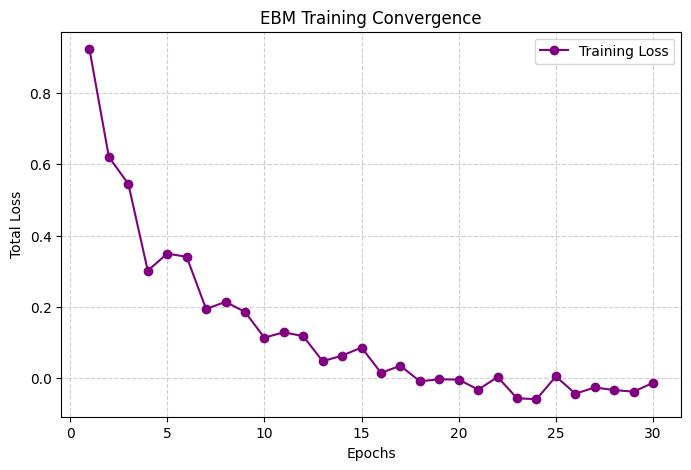

In [ ]:
# TODO: Plot loss over epochs
plt.figure(figsize=(8, 5))
plt.plot(range(1, EPOCHS + 1), train_history['train_loss'], marker='o', color='purple', label='Training Loss')
plt.title("EBM Training Convergence")
plt.xlabel("Epochs")
plt.ylabel("Total Loss")
plt.grid(True, linestyle='--', alpha=0.6)
plt.legend()
plt.show()

Now visualize generated samples. (You can visualize images every few epochs to see the evolution of your network)

Real Images for Comparison:


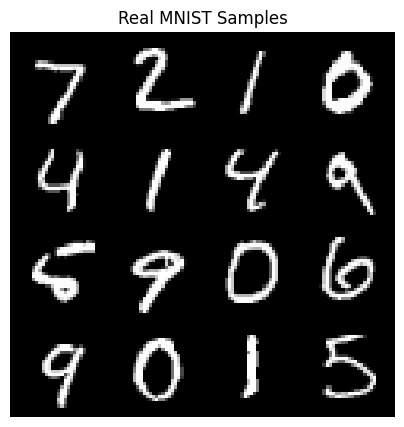


Generated Images:
Generating samples using η=400... (this may take a moment)


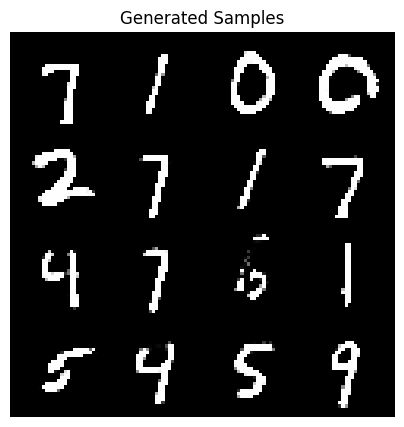

In [ ]:
# TODO: Generate and visualize images

print("Real Images for Comparison:")
visualize_real(testloader)

print("\nGenerated Images:")
visualize_generated(ebm_model, eta=400, alpha=ALPHA, sigma=SIGMA, loader=testloader)

If your resutls aren't great you can tune the hyperparameters to get better results or alternatively you can modify the dataset (resize, ...)to make it easier to learn the energy function.

# Q2: Denoising score matching

## Theory

### Problem 1: Implicit score matching

The objective of score matching is
$$
    \frac{1}{2} \mathbb{E}_{\pi}\bigl\| \mathbf{s}_{\boldsymbol{\theta}}(\mathbf{x}) - \nabla_\mathbf{x} \log \pi(\mathbf{x}) \bigr\|^2_2 \rightarrow \min_{\boldsymbol{\theta}}.
$$

And we have already known one possible solution for this task. It is denoising score matching.

Here our goal is to derive one more way to solve the initial score matching problem. It is called **implicit score matching**.

Let consider 1-d case ($x \in \mathbb{R}$).
Prove that
$$
\frac{1}{2} \mathbb{E}_{\pi}\bigl\| s_{\boldsymbol{\theta}}(x) - \nabla_x \log \pi(x) \bigr\|^2_2 = \mathbb{E}_{\pi}\left[ \frac{1}{2}s^2_{\boldsymbol{\theta}}(x) + \nabla_{x} s_{\boldsymbol{\theta}}(x) \right] + \text{const}.
$$

- **Question:** Why is the expression at the right hand side better than the left one?
  

- **Question:** Why do we not use this expression instead of denoising score matching?


- **Question:** Why do we consider only 1-d case?



### Problem 2: Conditioned reverse distribution for NCSN

The distribution $q(\mathbf{x}_{t-1} | \mathbf{x}_t, \mathbf{x}_0)$ plays the crucial role in the DDPM.

Find the parameters of this Normal distribution for the NCSN Markov chain $\mathbf{x}_t = \mathbf{x}_0 + \sigma_t \cdot \boldsymbol{\epsilon}$.

**Note:** in this case the mean should be the convex combination of $\mathbf{x}_t$ and $\mathbf{x}_0$ (this differs from the DDPM Markov chain).

### Answers to Theoretical Questions

**Problem 1: Implicit Score Matching**

* **Why is the expression at the right hand side better than the left one?**
    The left-hand side requires direct knowledge of $\nabla_x \log \pi(x)$, which is the score of the true, unknown data distribution. Since we only have a dataset of samples and not the analytical density function, computing this term is impossible. The right-hand side is derived via integration by parts, isolating the unknown data distribution entirely into the expectation $\mathbb{E}_\pi$. Inside the expectation, the terms $\frac{1}{2}s^2_{\boldsymbol{\theta}}(x) + \nabla_{x} s_{\boldsymbol{\theta}}(x)$ depend *only* on our neural network model. This makes the objective entirely tractable because we can simply approximate the expectation empirically using the samples from our dataset.

* **Why do we not use this expression instead of denoising score matching?**
    If we extend the right-hand expression to $d$-dimensional space, the derivative $\nabla_x s_{\boldsymbol{\theta}}(x)$ transforms into the divergence of the score network, denoted as $\nabla \cdot \mathbf{s}_{\boldsymbol{\theta}}(\mathbf{x})$, which equates to the trace of the Jacobian matrix. Calculating the exact trace of a neural network's Jacobian requires $d$ independent backward passes (one for each input dimension). For high-dimensional data like images, computing this trace is so computationally demanding that it becomes practically unusable. Denoising Score Matching solves this by perturbing the data, which bypasses the need to compute the Jacobian entirely.

* **Why do we consider only 1-d case?**
    In a 1-dimensional space, the divergence term simplifies to a single scalar derivative $\frac{\partial s_{\boldsymbol{\theta}}(x)}{\partial x}$. This only requires one simple backpropagation step to compute, making the implicit score matching objective highly efficient and perfectly feasible without hitting the scaling limitations of higher dimensions.

---

**Problem 2: Conditioned reverse distribution for NCSN**

For the Noise Conditional Score Network (NCSN), the marginal distribution at step $t$ given $\mathbf{x}_0$ is defined as:
$$
q(\mathbf{x}_t | \mathbf{x}_0) = \mathcal{N}(\mathbf{x}_t; \mathbf{x}_0, \sigma_t^2 \mathbf{I})
$$
And similarly for $t-1$:
$$
q(\mathbf{x}_{t-1} | \mathbf{x}_0) = \mathcal{N}(\mathbf{x}_{t-1}; \mathbf{x}_0, \sigma_{t-1}^2 \mathbf{I})
$$
To satisfy the Markov property such that the marginals hold, the forward transition probability must be:
$$
q(\mathbf{x}_t | \mathbf{x}_{t-1}) = \mathcal{N}(\mathbf{x}_t; \mathbf{x}_{t-1}, (\sigma_t^2 - \sigma_{t-1}^2) \mathbf{I})
$$
We want to find the posterior distribution $q(\mathbf{x}_{t-1} | \mathbf{x}_t, \mathbf{x}_0)$. Using Bayes' theorem for Gaussians:
$$
q(\mathbf{x}_{t-1} | \mathbf{x}_t, \mathbf{x}_0) = \frac{q(\mathbf{x}_t | \mathbf{x}_{t-1}) q(\mathbf{x}_{t-1} | \mathbf{x}_0)}{q(\mathbf{x}_t | \mathbf{x}_0)}
$$
Since all terms are Gaussian, the posterior $q(\mathbf{x}_{t-1} | \mathbf{x}_t, \mathbf{x}_0)$ is also a Gaussian distribution, $\mathcal{N}(\tilde{\boldsymbol{\mu}}_t, \tilde{\sigma}_t^2 \mathbf{I})$. We can find its parameters by completing the square in the exponent. 

**1. Finding the Variance ($\tilde{\sigma}_t^2$):**
The precision (inverse variance) of the posterior is the sum of the precisions of the two Gaussian components in the numerator:
$$
\frac{1}{\tilde{\sigma}_t^2} = \frac{1}{\sigma_t^2 - \sigma_{t-1}^2} + \frac{1}{\sigma_{t-1}^2} = \frac{\sigma_{t-1}^2 + \sigma_t^2 - \sigma_{t-1}^2}{\sigma_{t-1}^2(\sigma_t^2 - \sigma_{t-1}^2)} = \frac{\sigma_t^2}{\sigma_{t-1}^2(\sigma_t^2 - \sigma_{t-1}^2)}
$$
Inverting this gives the variance:
$$
\tilde{\sigma}_t^2 = \frac{\sigma_{t-1}^2 (\sigma_t^2 - \sigma_{t-1}^2)}{\sigma_t^2}
$$

**2. Finding the Mean ($\tilde{\boldsymbol{\mu}}_t$):**
The mean is calculated by multiplying the posterior variance by the sum of the precision-weighted means:
$$
\tilde{\boldsymbol{\mu}}_t = \tilde{\sigma}_t^2 \left( \frac{\mathbf{x}_t}{\sigma_t^2 - \sigma_{t-1}^2} + \frac{\mathbf{x}_0}{\sigma_{t-1}^2} \right)
$$
Substituting $\tilde{\sigma}_t^2$ into the equation:
$$
\tilde{\boldsymbol{\mu}}_t = \frac{\sigma_{t-1}^2 (\sigma_t^2 - \sigma_{t-1}^2)}{\sigma_t^2} \left( \frac{\mathbf{x}_t}{\sigma_t^2 - \sigma_{t-1}^2} \right) + \frac{\sigma_{t-1}^2 (\sigma_t^2 - \sigma_{t-1}^2)}{\sigma_t^2} \left( \frac{\mathbf{x}_0}{\sigma_{t-1}^2} \right)
$$
Simplifying the terms yields:
$$
\tilde{\boldsymbol{\mu}}_t = \frac{\sigma_{t-1}^2}{\sigma_t^2} \mathbf{x}_t + \frac{\sigma_t^2 - \sigma_{t-1}^2}{\sigma_t^2} \mathbf{x}_0
$$
Notice that the coefficients $\frac{\sigma_{t-1}^2}{\sigma_t^2}$ and $\frac{\sigma_t^2 - \sigma_{t-1}^2}{\sigma_t^2}$ sum perfectly to $1$, confirming that the posterior mean is exactly a convex combination of $\mathbf{x}_t$ and $\mathbf{x}_0$.

In [ ]:
import numpy as np
from typing import Tuple, List
import math

import torch
import torch.nn as nn
import torch.utils.data as data
from torch.nn import functional as F

if torch.cuda.is_available():
    DEVICE = "cuda"
    print('GPU found :)')
else:
    DEVICE = "cpu"
    print('GPU not found :(')

GPU found :)


# NOTE: Don't change this part

In [ ]:
from typing import Dict, List, Literal, Optional, Tuple
from collections import defaultdict
from IPython.display import clear_output
from contextlib import nullcontext

import numpy as np
from matplotlib import pyplot as plt
from tqdm.auto import tqdm

import torch
from torch import nn
from torch.utils.data import Dataset, DataLoader
from torch.optim.optimizer import Optimizer
from torch.optim.lr_scheduler import LRScheduler

import torchvision
from torchvision.utils import make_grid
from sklearn.datasets import make_moons



TICKS_FONT_SIZE = 12
LEGEND_FONT_SIZE = 12
LABEL_FONT_SIZE = 14
TITLE_FONT_SIZE = 16

TOY_DATASETS = ["moons"]
IMAGE_DATASETS = ["mnist", "cifar10"]

def prepare_images(
    train_data: np.ndarray,
    test_data: np.ndarray,
    flatten: bool = False,
    binarize: bool = True
) -> Tuple[np.ndarray, np.ndarray]:
    if binarize:
        train_data = (train_data > 128).astype("int64")
        test_data = (test_data > 128).astype("int64")
    else:
        train_data = train_data / 255.0
        test_data = test_data / 255.0

    train_data = np.transpose(train_data, (0, 3, 1, 2))
    test_data = np.transpose(test_data, (0, 3, 1, 2))

    if flatten:
        train_data = train_data.reshape(len(train_data.shape[0]), -1)
        test_data = test_data.reshape(len(train_data.shape[0]), -1)

    return train_data, test_data

def load_MNIST(with_targets: bool = False) -> Tuple[np.ndarray, Optional[np.ndarray], np.ndarray, Optional[np.ndarray]]:
    train_dataset = torchvision.datasets.MNIST(root="./", train=True, download=True)
    test_dataset = torchvision.datasets.MNIST(root="./", train=False, download=True)

    transform = torchvision.transforms.Resize((14, 14))
    train_data = torch.stack([transform(img.unsqueeze(0)) for img in train_dataset.data]).numpy().transpose(0, 2, 3, 1)
    test_data = torch.stack([transform(img.unsqueeze(0)) for img in test_dataset.data]).numpy().transpose(0, 2, 3, 1)

    if with_targets:
        train_labels, test_labels = train_dataset.targets.numpy(), test_dataset.targets.numpy()
        return train_data, train_labels, test_data, test_labels

    return train_data, None, test_data, None


def load_CIFAR10(with_targets: bool = False) -> Tuple[np.ndarray, Optional[np.ndarray], np.ndarray, Optional[np.ndarray]]:
    train_dataset = torchvision.datasets.CIFAR10(root="./", train=True, download=True)
    test_dataset = torchvision.datasets.CIFAR10(root="./", train=False, download=True)
    train_data, test_data = train_dataset.data, test_dataset.data

    if with_targets:
        train_labels, test_labels = (
            train_dataset.targets.numpy(),
            test_dataset.targets.numpy(),
        )
        return train_data, train_labels, test_data, test_labels

    return train_data, None, test_data, None

def load_moons(
    size: int,
    with_targets: bool
) -> Tuple[np.ndarray, Optional[np.ndarray], np.ndarray, Optional[np.ndarray]]:
    data, labels = make_moons(n_samples=size, noise=0.1)
    split = int(0.8 * size)
    train_data, test_data = data[:split], data[split:]

    if with_targets:
        train_labels, test_labels = labels[:split], labels[split:]
        return train_data, train_labels, test_data, test_labels

    return train_data, None, test_data, None


def _load_dataset(
    name: Literal["mnist", "cifar10", "moons"],
    size: Optional[int] = None,
    with_targets: bool = False,
) -> Tuple[np.ndarray, Optional[np.ndarray], np.ndarray, Optional[np.ndarray]]:
    if name == "mnist":
        return load_MNIST(with_targets=with_targets)
    elif name == "cifar10":
        return load_CIFAR10(with_targets=with_targets)
    elif name == "moons":
        if size is None:
            raise ValueError("Size must be specifed for 'moons' dataset!")
        return load_moons(size=size, with_targets=with_targets)
    else:
        raise ValueError("The argument name must have the values 'mnist', 'cifar10' or 'moons'!")


def load_dataset(
    name: str,
    size: Optional[int] = None,
    flatten: bool = False,
    binarize: bool = True,
    with_targets: bool = False
) -> Tuple[np.ndarray, Optional[np.ndarray], np.ndarray, Optional[np.ndarray]]:

    train_data, train_labels, test_data, test_labels = _load_dataset(
        name, size=size,
        with_targets=with_targets
    )
    train_data = train_data.astype("float32")
    test_data = test_data.astype("float32")

    if name in IMAGE_DATASETS:
        train_data, test_data = prepare_images(
            train_data,
            test_data,
            flatten=flatten,
            binarize=binarize
        )

    if with_targets:
        return train_data, train_labels, test_data, test_labels

    return train_data, test_data

class LabeledDataset(Dataset):
    def __init__(self, data, labels):
        super().__init__()
        self.data = data
        self.labels = labels

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        x = self.data[idx]
        y = self.labels[idx]
        return x, y


def plot_training_curves(
    epochs: int,
    train_losses: Dict[str, List[float]],
    test_losses: Optional[Dict[str, List[float]]],
    logscale_y: bool = False,
    logscale_x: bool = False,
) -> None:
    if test_losses is not None:
        n_test = len(test_losses[list(train_losses.keys())[0]])
        x_test = np.arange(n_test)

    n_train = len(train_losses[list(train_losses.keys())[0]])
    x_train = np.linspace(0, epochs - 1, n_train)


    plt.figure()
    for key, value in train_losses.items():
        plt.plot(x_train, value, label=key + "_train")

    if test_losses is not None:
        for key, value in test_losses.items():
            plt.plot(x_test, value, label=key + "_test")

    if logscale_y:
        plt.semilogy()

    if logscale_x:
        plt.semilogx()

    plt.legend(fontsize=LEGEND_FONT_SIZE)
    plt.xlabel("Epoch", fontsize=LABEL_FONT_SIZE)
    plt.ylabel("Loss", fontsize=LABEL_FONT_SIZE)
    plt.xticks(fontsize=TICKS_FONT_SIZE)
    plt.yticks(fontsize=TICKS_FONT_SIZE)
    plt.grid()
    plt.show()


def show_samples(
    samples: np.ndarray | torch.Tensor,
    title: str,
    figsize: Optional[Tuple[int, int]] = None,
    nrow: Optional[int] = None,
    normalize: bool = False
) -> None:
    if isinstance(samples, np.ndarray):
        samples = torch.tensor(samples)
    if nrow is None:
        nrow = int(np.sqrt(len(samples)))

    grid_samples = make_grid(samples, nrow=nrow, normalize=normalize, scale_each=True)
    grid_img = grid_samples.permute(1, 2, 0)

    plt.figure(figsize=(6, 6) if figsize is None else figsize)
    plt.title(title, fontsize=TITLE_FONT_SIZE)
    plt.imshow(grid_img)
    plt.axis("off")
    plt.show()


def visualize_images(data: np.ndarray, title: str) -> None:
    idxs = np.random.choice(len(data), replace=False, size=(100,))
    images = data[idxs]
    show_samples(images, title)


def visualize_2d_data(
    train_data: np.ndarray,
    test_data: np.ndarray,
    train_labels: Optional[str] = None,
    test_labels: Optional[str] = None,
    s: int = 10
) -> None:
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 5))
    ax1.set_title("train", fontsize=TITLE_FONT_SIZE)
    ax1.scatter(train_data[:, 0], train_data[:, 1], s=s, c=train_labels)
    ax1.tick_params(labelsize=LABEL_FONT_SIZE)
    ax2.set_title("test", fontsize=TITLE_FONT_SIZE)
    ax2.scatter(test_data[:, 0], test_data[:, 1], s=s, c=test_labels)
    ax2.tick_params(labelsize=LABEL_FONT_SIZE)
    plt.show()


def visualize_2d_samples(
    data: np.ndarray,
    title: str,
    labels: Optional[str] = None,
    xlabel: str = "x1",
    ylabel: str = "x2",
    s: int = 10
) -> None:
    plt.figure(figsize=(5, 5))
    plt.scatter(data[:, 0], data[:, 1], s=s, c=labels)
    plt.title(title, fontsize=TITLE_FONT_SIZE)
    plt.xticks(fontsize=TICKS_FONT_SIZE)
    plt.yticks(fontsize=TICKS_FONT_SIZE)
    if xlabel is not None:
        plt.xlabel(xlabel, fontsize=LABEL_FONT_SIZE)
    if ylabel is not None:
        plt.ylabel(ylabel, fontsize=LABEL_FONT_SIZE)
    plt.show()


def visualize_2d_densities(
    x_grid: np.ndarray,
    y_grid: np.ndarray,
    densities: np.ndarray,
    title: str,
    xlabel: Optional[str] = None,
    ylabel: Optional[str] = None,
) -> None:
    densities = densities.reshape([y_grid.shape[0], y_grid.shape[1]])
    plt.figure(figsize=(5, 5))
    plt.pcolor(x_grid, y_grid, densities)
    plt.pcolor(x_grid, y_grid, densities)

    plt.title(title, fontsize=TITLE_FONT_SIZE)
    plt.xticks(fontsize=TICKS_FONT_SIZE)
    plt.yticks(fontsize=TICKS_FONT_SIZE)
    if xlabel is not None:
        plt.xlabel(xlabel, fontsize=LABEL_FONT_SIZE)
    if ylabel is not None:
        plt.ylabel(ylabel, fontsize=LABEL_FONT_SIZE)
    plt.show()



class BaseModel(nn.Module):
    def __init__(self) -> None:
        super().__init__()

    @property
    def device(self):
        return next(self.parameters()).device

    def forward(self, x: torch.Tensor) -> torch.Tensor:
        raise NotImplementedError('Not implemented')

    def loss(self, x: torch.Tensor) -> Dict[str, torch.Tensor]:
        raise NotImplementedError('Not implemented')

    @torch.no_grad()
    def sample(self, n: int) -> np.ndarray:
        raise NotImplementedError('Not implemented')

def train_epoch(
    epoch: int,
    model: BaseModel,
    train_loader: DataLoader,
    optimizer: Optimizer,
    gradient_clip_val: Optional[float] = None,
    conditional: bool = False,
    device: str = "cpu",
    loss_key: str = "total_loss",
    use_amp: bool = False,
    scaler: Optional[torch.amp.GradScaler] = None,
) -> Dict[str, List[float]]:
    model.train()
    stats: Dict[str, List[float]] = defaultdict(list)
    
    for batch in tqdm(train_loader, desc=f"Training epoch {epoch}"):
        if conditional:
            x, y = batch
            x, y = x.to(device), y.to(device)
        else:
            x, y = batch.to(device), None
            
        optimizer.zero_grad()
        ctx = torch.amp.autocast("cuda") if use_amp else nullcontext()
        with ctx:
            losses = model.loss(x, y) if y is not None else model.loss(x)
            loss = losses[loss_key]

        if use_amp and scaler is not None:
            scaler.scale(loss).backward()
            if gradient_clip_val is not None:
                torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=gradient_clip_val)
            scaler.step(optimizer)
            scaler.update()
        else:
            loss.backward()
            if gradient_clip_val is not None:
                torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=gradient_clip_val)
            optimizer.step()

        for k, v in losses.items():
            stats[k].append(v.item())

    return stats


def eval_model(
    epoch: int,
    model: BaseModel,
    data_loader: DataLoader,
    conditional: bool = False,
    device: str = "cpu",
    use_amp: bool = False,
) -> Dict[str, float]:
    model.eval()
    stats: Dict[str, float] = defaultdict(float)
    
    with torch.no_grad():
        for batch in tqdm(data_loader, desc=f"Evaluating epoch {epoch}"):
            if conditional:
                x, y = batch
                x, y = x.to(device), y.to(device)
            else:
                x, y = batch.to(device), None
                
            ctx = torch.amp.autocast("cuda") if use_amp else nullcontext()
            with ctx:
                losses = model.loss(x, y) if y is not None else model.loss(x)
                
            for k, v in losses.items():
                stats[k] += v.item() * x.shape[0]

        for k in stats.keys():
            stats[k] /= len(data_loader.dataset)
            
    return stats


def check_samples_is_2d(samples: np.ndarray) -> bool:
    shape = samples.shape
    return len(shape) == 2 and shape[1] == 2


def train_model(
    model: BaseModel,
    train_loader: DataLoader,
    test_loader: DataLoader,
    epochs: int,
    optimizer: Optimizer,
    scheduler: Optional[LRScheduler] = None,
    conditional: bool = False,
    loss_key: str = "total_loss",
    n_samples: int = 100,
    visualize_samples: bool = True,
    logscale_y: bool = False,
    logscale_x: bool = False,
    device: str = "cpu",
):

    train_losses: Dict[str, List[float]] = defaultdict(list)
    test_losses: Dict[str, List[float]] = defaultdict(list)
    model = model.to(device)
    print("Start of the training")

    for epoch in range(1, epochs + 1):
        train_loss = train_epoch(
            epoch=epoch,
            model=model,
            train_loader=train_loader,
            optimizer=optimizer,
            conditional=conditional,
            device=device,
            loss_key=loss_key,
        )
        if scheduler is not None:
            scheduler.step()
            
        test_loss = eval_model(
            epoch=epoch,
            model=model,
            data_loader=test_loader,
            conditional=conditional,
            device=device,
        )

        for k in train_loss.keys():
            train_losses[k].extend(train_loss[k])
            test_losses[k].append(test_loss[k])

        epoch_loss = np.mean(train_loss[loss_key])
        if visualize_samples:
            with torch.no_grad():
                samples = model.sample(n_samples)
                if isinstance(samples, torch.Tensor):
                    samples = samples.cpu().detach().numpy()

            clear_output(wait=True)
            title = f"Samples, epoch: {epoch}, {loss_key}: {epoch_loss:.3f}"
            if check_samples_is_2d(samples):
                visualize_2d_samples(samples, title=title)
            else:
                show_samples(samples, title=title)
            plot_training_curves(epoch, train_losses, test_losses, logscale_y, logscale_x)
        else:
            clear_output(wait=True)
            print(f"Epoch: {epoch}, loss: {epoch_loss}")
            plot_training_curves(epoch, train_losses, test_losses, logscale_y, logscale_x)

    print("End of the training")

/home/mahdi/Videos/Gosas/AI/.venv/lib/python3.14/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


## Task 2: Denoising score matching for 2D data

In this task you will implement the denoising score matching model to the 2D moons dataset.

Let's take a look at dataset samples.

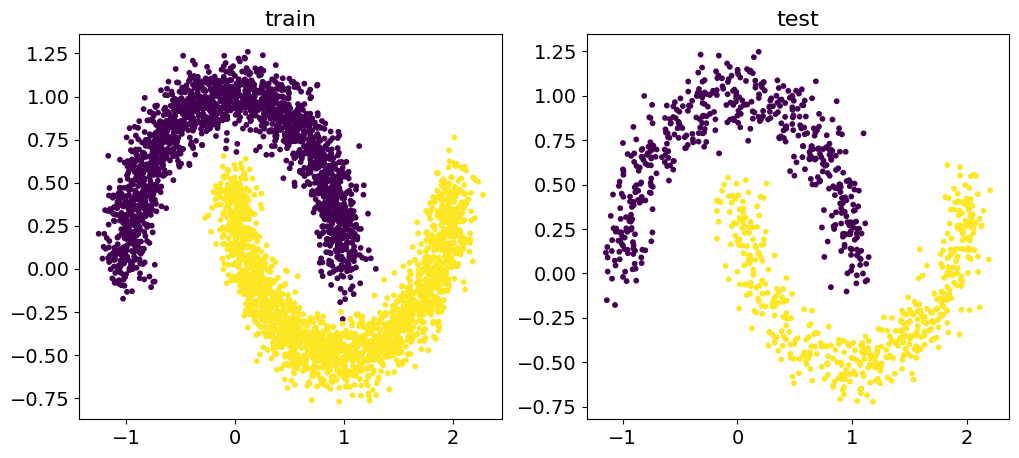

In [ ]:
COUNT = 5000

train_data, train_labels, test_data, test_labels = load_dataset('moons', size=COUNT, with_targets=True)
visualize_2d_data(train_data, test_data, train_labels, test_labels)

Let recall the theory of denoising score matching.

The idea is the following. We define the score function
$$
    \mathbf{s}_{\boldsymbol{\theta}}(\mathbf{x}) = \nabla_{\mathbf{x}}\log p(\mathbf{x}| \boldsymbol{\theta}).
$$

Then we minimize the Fisher divergence to obtain the score function:
$$
    D_F(\pi, p) = \frac{1}{2}\mathbb{E}_{\pi}\bigl\| \mathbf{s}_{\boldsymbol{\theta}}(\mathbf{x}) - \nabla_{\mathbf{x}} \log \pi(\mathbf{x}) \bigr\|^2_2 \rightarrow \min_{\boldsymbol{\theta}}
$$.

If we had the score function, we could use the Langevin dynamics to sample from our model:
$$
    \mathbf{x}_{l + 1} = \mathbf{x}_l + \frac{\eta}{2} \cdot \nabla_{\mathbf{x}_l} \log p(\mathbf{x}_l | \boldsymbol{\theta}) + \sqrt{\eta} \cdot \boldsymbol{\epsilon}, \quad \boldsymbol{\epsilon} \sim \mathcal{N}(0, \mathbf{I}).
$$

However, Fisher divergence is intractable and we use the noising procedure to get noised samples $\mathbf{x}_{\sigma} = \mathbf{x} + \sigma \cdot \boldsymbol{\epsilon}$.

Minimizing the Fisher divergence for the noisy samples is equivalent to the following objective:
$$
\mathbb{E}_{q(\mathbf{x}_{\sigma})}\bigl\| \mathbf{s}_{\boldsymbol{\theta}, \sigma}(\mathbf{x}_{\sigma}) - \nabla_{\mathbf{x}_{\sigma}} \log q(\mathbf{x}_{\sigma}) \bigr\|^2_2 = \mathbb{E}_{\pi(\mathbf{x})} \mathbb{E}_{q(\mathbf{x}_{\sigma} | \mathbf{x})}\bigl\| \mathbf{s}_{\boldsymbol{\theta}, \sigma}(\mathbf{x}_{\sigma}) - \nabla_{\mathbf{x}_{\sigma}} \log q(\mathbf{x}_{\sigma} | \mathbf{x}) \bigr\|^2_2 + \text{const}(\boldsymbol{\theta}).
$$

Here
$$
    \log q(\mathbf{x}_{\sigma} | \mathbf{x}) = - \frac{\mathbf{x}_{\sigma} - \mathbf{x}}{\sigma^2} = - \frac{\boldsymbol{\epsilon}}{\sigma}.
$$

Therefore, the objective of the denoising score matching is

$$
\mathbb{E}_{\pi(\mathbf{x})} \mathbb{E}_{q(\mathbf{x}_{\sigma} | \mathbf{x})}\bigl\| \mathbf{s}_{\boldsymbol{\theta}, \sigma}(\mathbf{x}_{\sigma}) + \frac{\boldsymbol{\epsilon}}{\sigma} \bigr\|^2_2 \rightarrow \min_{\boldsymbol{\theta}}.
$$

In [ ]:
class DenoisingScoreMatcher(BaseModel):
    def __init__(
            self,
            score_model: nn.Module,
            input_shape: Tuple[int],
            sigma: float
        ):
        super().__init__()

        self.score_model = score_model
        self.input_shape = input_shape
        self.sigma = sigma

    def forward(self, x: torch.Tensor):
        # ====
        # your code
        # sample gaussian noise
        # perturb samples using the noise and sigma

        noise_vector = torch.randn_like(x)
        x_perturbed = x + (self.sigma * noise_vector)

        # =====

        # calculate the score model
        s = self.score_model(x_perturbed)

        # ====
        # your code
        # compute the loss

        target_score = -noise_vector / self.sigma
        loss = (s - target_score) ** 2

        # =====
        return loss

    def loss(self, x: torch.Tensor):
        return {"total_loss": self(x).mean(dim=0).sum()}

    def langevin_dynamics(self, x: torch.Tensor, num_steps: int, eta: float):
        # =====
        # your code
        # apply Langevin dynamics in for-cycle to the starting point x

        with torch.no_grad():
            for _ in range(int(num_steps)):
                current_score = self.score_model(x)
                z = torch.randn_like(x)
                x = x + (0.5 * eta * current_score) + (math.sqrt(eta) * z)

        # =====
        return x

    def sample(self, num_samples: int = 64, num_steps: int=100, eta: float = 0.01):
        with torch.no_grad():
            # we sample x_0 from U[-1, 1]
            x0 = 2. * torch.rand_like(torch.empty(num_samples, *self.input_shape)) - 1.
            x0 = x0.to(self.device)

            # run langevine dynamics
            x = self.langevin_dynamics(x0, num_steps=num_steps, eta=eta)
        return x


def test_denoiser_score_matcher():
    matcher = DenoisingScoreMatcher(
        score_model=nn.Linear(2, 2),
        input_shape=(2,),
        sigma=0.1
    )
    x = torch.rand(16, 2)
    assert x.size() == matcher(x).size()
    loss = matcher.loss(x)["total_loss"]
    assert len(loss.size()) == 0
    assert list(matcher.sample(4).size()) == [4, 2]


test_denoiser_score_matcher()

That's all!

And now we are ready to train our model.

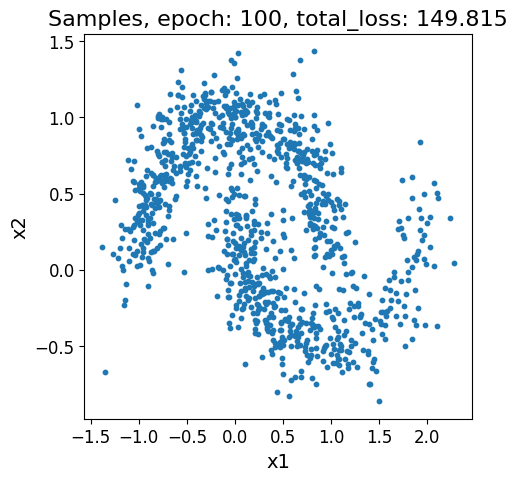

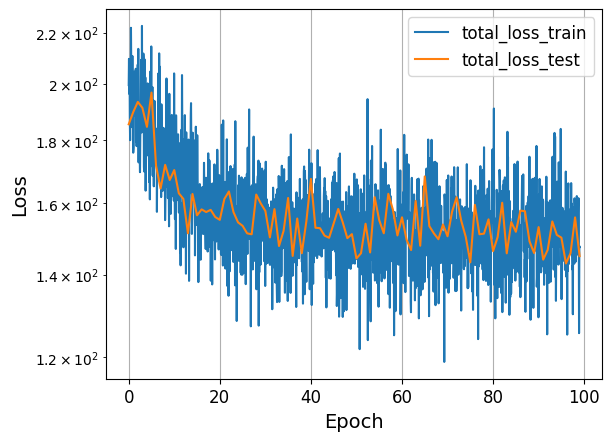

End of the training


In [32]:
# %%
# ====
# your code
# choose these parameters
BATCH_SIZE = 256
EPOCHS = 100
LR = 1e-3
HIDDEN_SIZE = 256
SIGMA = 0.1
# ====

train_loader = data.DataLoader(train_data, batch_size=BATCH_SIZE, shuffle=True)
test_loader = data.DataLoader(test_data, batch_size=BATCH_SIZE, shuffle=True)

# ====
# your code
# define sequential model
# it is enough to use the sequence of Linear layers with activations

def build_dense_score_net(input_dim: int, hidden_dim: int, depth: int = 4) -> nn.Sequential:
    """Helper to dynamically build the sequential score network."""
    layers = []
    layers.append(nn.Linear(input_dim, hidden_dim))
    
    for _ in range(depth):
        layers.append(nn.SiLU())
        layers.append(nn.LayerNorm(hidden_dim))
        layers.append(nn.Linear(hidden_dim, hidden_dim))
        
    layers.append(nn.SiLU())
    layers.append(nn.LayerNorm(hidden_dim))
    layers.append(nn.Linear(hidden_dim, input_dim))
    return nn.Sequential(*layers)

score_model = build_dense_score_net(input_dim=2, hidden_dim=HIDDEN_SIZE)

# ====

matcher = DenoisingScoreMatcher(
    score_model=score_model, input_shape=(2,), sigma=SIGMA
)

# choose any optimizer/scheduler as you want
optimizer = torch.optim.Adam(matcher.parameters(), lr=LR)
scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=1, gamma=0.95)

train_model(
    matcher,
    train_loader,
    test_loader,
    epochs=EPOCHS,
    optimizer=optimizer,
    scheduler=scheduler,
    device=DEVICE,
    n_samples=1024,
    visualize_samples=True,
    logscale_y=True,
)

Let sample from our model. Experiment with number of steps and $\eta$ for Langevin dynamics.

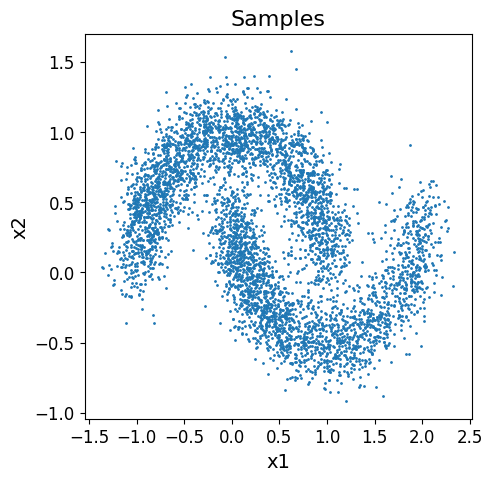

In [ ]:
# ====
# your code
# choose these parameters
NUM_STEPS = 2000
ETA = 1e-3
# ====

samples = matcher.sample(num_samples=5000, num_steps=NUM_STEPS, eta=ETA).cpu()

visualize_2d_samples(samples, title="Samples", s=1)

## Noise Conditioned Score Network for MNIST

Now we try to extend our model to the NCSN. It means that we have to add multiple noise scales.

**Note!** Here we rescale the images to $[-1, 1]$, which will help us with training of the NCSN.

100%|██████████| 9.91M/9.91M [00:14<00:00, 671kB/s] 
100%|██████████| 28.9k/28.9k [00:00<00:00, 177kB/s]
100%|██████████| 1.65M/1.65M [00:03<00:00, 505kB/s]
100%|██████████| 4.54k/4.54k [00:00<00:00, 13.6MB/s]


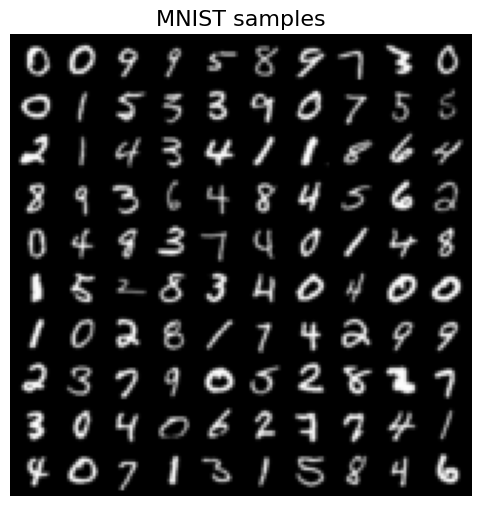

In [ ]:
train_data, test_data = load_dataset("mnist", flatten=False, binarize=False)
visualize_images(train_data, "MNIST samples")

train_data, test_data = 2 * train_data - 1, 2 * test_data - 1


First, we'll define the UNet's core component. It is the `ResBlock`, which enhances standard ResNet blocks with timestep embeddings.

In [ ]:
class ResBlock(nn.Module):
    def __init__(self, in_channels, out_channels, t_dim, dropout):
        super().__init__()

        self.temb_proj = nn.Sequential(nn.SiLU(), nn.Linear(t_dim, out_channels))

        # ====
        # your code
        # create two convolutional blocks of nn.Sequential
        # first block should take raw input
        # second block should take the output of the first block with added time and class embeddings
        # it is preferrable to use nn.GroupNorm (~8 groups), nn.SiLU and nn.Dropout
        def get_groups(channels: int) -> int:
            for g in [8, 4, 2, 1]:
                if channels % g == 0:
                    return g
            return 1

        self.conv_block_1 = nn.Sequential(
            nn.GroupNorm(get_groups(in_channels), in_channels),
            nn.SiLU(),
            nn.Conv2d(in_channels, out_channels, kernel_size=3, padding=1)
        )
        
        self.conv_block_2 = nn.Sequential(
            nn.GroupNorm(get_groups(out_channels), out_channels),
            nn.SiLU(),
            nn.Dropout(p=dropout),
            nn.Conv2d(out_channels, out_channels, kernel_size=3, padding=1)
        )
        # ====

        self.shortcut = nn.Conv2d(in_channels, out_channels, kernel_size=1) if in_channels != out_channels else nn.Identity()

    def forward(self, x, temb):
        # ====
        # your code
        # 1) pass x through the first block
        # 2) add time embedding (unsqueeze it to the right shape)
        # 3) pass the result through the second block
        # 4) add the shortcut

        h = self.conv_block_1(x)
        
        t_emb_reshaped = self.temb_proj(temb)[..., None, None]
        h = h + t_emb_reshaped
        
        h = self.conv_block_2(h)
        
        h = h + self.shortcut(x)
        # ====
        return h

The `DownsampleBlock` and `UpsampleBlock` implement the UNet's characteristic encoder-decoder structure, managing resolution changes as features flow through the network.

In [ ]:
class DownsampleBlock(nn.Module):
    def __init__(self, channels: int):
        super().__init__()
        # ====
        # your code
        # define convolutional layer that:
        # 1) does not change the number of channels
        # 2) reduces the size of the image twice
        self.down = nn.Conv2d(channels, channels, kernel_size=3, stride=2, padding=1)
        # ====

    def forward(self, input_tensor: torch.Tensor, *args) -> torch.Tensor:
        # ====
        # your code
        x = self.down(input_tensor)
        # ====
        return x

class UpsampleBlock(nn.Module):
    def __init__(self, channels: int):
        super().__init__()
        # ====
        # your code
        # define convolutional layer that:
        # 1) does not change the number of channels
        # 2) does not reduce the size of the image

        self.up = nn.Upsample(scale_factor=2.0, mode='bilinear', align_corners=False)
        self.conv = nn.Conv2d(channels, channels, kernel_size=3, stride=1, padding=1)
        # ====

    def forward(self, input_tensor: torch.Tensor, *args) -> torch.Tensor:
        # ====
        # your code
        # 1) upsample the input tensor using bilinear interpolation
        # 2) pass the result through the convolutional layer

        x = self.up(input_tensor)
        x = self.conv(x)
        # ====
        return x

Finally, we define the complete `UNet` - the neural network backbone of our diffusion model that handles both encoding and decoding with skip connections. Look at the code carefully.

In [ ]:
class UNet(nn.Module):
    def __init__(
        self,
        num_timesteps: int,
        hidden_channels: int,
        channel_multipliers: List[int],
        num_blocks: int = 1,
        dropout: float = 0.1
    ):
        super().__init__()

        temb_dim = hidden_channels * 4
        self.time_embedding = nn.Embedding(num_timesteps, temb_dim)
        self.head = nn.Conv2d(1, hidden_channels, kernel_size=3, stride=1, padding=1)
        channel_list, curr_channels = [hidden_channels], hidden_channels

        # initialization of downsample blocks
        self.downsample_blocks = nn.ModuleList()
        for idx, scale in enumerate(channel_multipliers):
            out_channels = hidden_channels * scale
            is_last = (idx == len(channel_multipliers) - 1)

            # make multiple ResBlocks at each scale
            for _ in range(num_blocks):
                # at each channel_multipliers scale we add ResBlock
                # last block has attention
                self.downsample_blocks.append(
                    ResBlock(curr_channels, out_channels, temb_dim, dropout)
                )
                curr_channels = out_channels
                channel_list.append(curr_channels)

            # add downsample block if not last block
            if not is_last:
                self.downsample_blocks.append(DownsampleBlock(curr_channels))
                channel_list.append(curr_channels)

        # initialization of bottleneck block
        self.bottleneck = nn.ModuleList([
            ResBlock(curr_channels, curr_channels, temb_dim, dropout),
            ResBlock(curr_channels, curr_channels, temb_dim, dropout)
        ])

        # initialization of upsample blocks
        self.upsample_blocks = nn.ModuleList()
        for idx, scale in reversed(list(enumerate(channel_multipliers))):
            out_channels = hidden_channels * scale
            is_first, is_last = (idx == 0), (idx == len(channel_multipliers) - 1)

            # make multiple ResBlocks at each scale
            for _ in range(num_blocks + 1):
                # at each reverse channel_multipliers scale we add ResBlock
                # first block has attention
                self.upsample_blocks.append(
                    ResBlock(channel_list.pop() + curr_channels, out_channels, temb_dim, dropout)
                )

                curr_channels = out_channels

            # add upsample block if not last block
            if not is_first:
                self.upsample_blocks.append(UpsampleBlock(curr_channels))

        self.tail = nn.Sequential(
            nn.GroupNorm(8, curr_channels),
            nn.SiLU(),
            nn.Conv2d(curr_channels, 1, kernel_size=3, stride=1, padding=1)
        )

    def forward(self, x, t):
        temb = self.time_embedding(t)

        h = self.head(x)
        skip_connections = [h] # save intermediate results for skip connections

        # downsample
        for layer in self.downsample_blocks:
            h = layer(h, temb)
            skip_connections.append(h) # save intermediate results for skip connections

        # bottleneck
        for layer in self.bottleneck:
            h = layer(h, temb)

        # upsample
        for layer in self.upsample_blocks:
            if isinstance(layer, ResBlock): # apply skip connection
                skip_connection = skip_connections.pop()
                h = torch.cat([h, skip_connection], dim=1)
            h = layer(h, temb)

        h = self.tail(h)
        return h

def test_unet():
    model = UNet(
        num_timesteps=10,
        hidden_channels=128,
        # Changed to [1, 2] to prevent spatial dimension mismatch 
        # since our dataset images are 14x14
        channel_multipliers=[1, 2], 
        num_blocks=2
    )
    x = torch.rand((2, 1, 14, 14))
    t = torch.zeros(size=(2,), dtype=torch.long)
    out1 = model(x, t)
    t = torch.ones(size=(2,), dtype=torch.long)
    out2 = model(x, t)
    assert not np.allclose(out1.detach().numpy(), out2.detach().numpy())


test_unet()

Now lets define the main model.

We will use the sequence of the noise levels: $\sigma_1 < \sigma_2 < \dots < \sigma_T$. In this task it will be the geometric progression.
And we will perturb the original data with the different noise levels to obtain
$$
\mathbf{x}_t = \mathbf{x} + \sigma_t \cdot \boldsymbol{\epsilon}, \quad \mathbf{x}_t \sim q(\mathbf{x}_t).
$$

Our training objective:
$$
    \sum_{t=1}^T \frac{\sigma_t^2}{\sigma_T^2} \mathbb{E}_{\pi(\mathbf{x})} \mathbb{E}_{q(\mathbf{x}_t | \mathbf{x})}\bigl\| \mathbf{s}_{\boldsymbol{\theta}, \sigma_t}(\mathbf{x}_t) - \nabla_{\mathbf{x}_{\sigma}} \log q(\mathbf{x}_t | \mathbf{x}) \bigr\|^2_2 \rightarrow \min_{\boldsymbol{\theta}}
$$
But instead of doing the honest summation we will sample one timestamp for each sample.

We will use annealed Langevin dynamics to sample from our model:
1. Sample $\mathbf{x}_0 \sim \mathcal{N}(0, \sigma_T^2 \cdot \mathbf{I}) \approx q(\mathbf{x}_T)$.
2. Apply $L$ steps of Langevin dynamic
$$
    \mathbf{x}_l = \mathbf{x}_{l-1} + \frac{\eta_t}{2} \cdot \mathbf{s}_{\boldsymbol{\theta}, \sigma_t}(\mathbf{x}_{l - 1}) + \sqrt{\eta_t} \cdot \boldsymbol{\epsilon}_l.
$$
3. Update $\mathbf{x}_0 := \mathbf{x}_L$ and choose the next $\sigma_t$.
4. Repeat it for all sigmas.

**Note:** use the following formula for $\eta_t = \epsilon \cdot \frac{\sigma_t^2}{\sigma_T^2}$ ($\epsilon$ is a small number that is a hyperparameter of the sampling).

In [ ]:
class NoiseConditionedScoreNetwork(BaseModel):
    def __init__(
            self,
            input_shape: Tuple[int, int],
            sigmas: List[float],
            hidden_channels: int,
            channel_multipliers: List[int],
            num_blocks: int
        ):
        super().__init__()

        self.score_model = UNet(
            num_timesteps=len(sigmas),
            hidden_channels=hidden_channels,
            channel_multipliers=channel_multipliers,
            num_blocks=num_blocks
        )
        self.input_shape = input_shape
        self.sigmas = torch.FloatTensor(sorted(sigmas, reverse=True))

    def forward(self, x: torch.Tensor):
        self.sigmas = self.sigmas.to(self.device)
        batch_size = x.shape[0]
        # ====
        # your code
        # sample gaussian noise
        # sample timestamps for each datapoint in the batch
        # choose sigmas for these datapoints
        # add noises to the x samples
        z = torch.randn_like(x)
        t = torch.randint(0, len(self.sigmas), (batch_size,), device=x.device, dtype=torch.long)
        sigma_t = self.sigmas[t].view(batch_size, 1, 1, 1)
        noisy_x = x + (sigma_t * z)
        # =====

        # calculate the score model
        s = self.score_model(noisy_x, t)

        # ====
        # your code
        # compute the loss
        # it is mse between score function and gradient of the normal distribution (do not forget the coefficient before the mse)
        target_score = -z / sigma_t
        lambda_t = (sigma_t ** 2) / (self.sigmas[0] ** 2)
        
        loss = lambda_t * (s - target_score) ** 2
        # =====
        return loss

    def loss(self, x: torch.Tensor):
        return {"total_loss": self(x).mean(dim=0).sum()}

    def annealed_langevin_dynamics(self, x: torch.Tensor, num_steps: int, eps: float):
        # =====
        # your code
        # here we will have 2 cycles: one for sigmas, one for Langevin sampling
        # start with the largest sigma, apply Langevin dynamic for it and move to the next sigma

        self.sigmas = self.sigmas.to(self.device)
        sigma_max_sq = self.sigmas[0] ** 2
        batch_size = x.shape[0]

        for idx, current_sigma in enumerate(self.sigmas):
            eta_t = eps * (current_sigma ** 2) / sigma_max_sq
            
            t_tensor = torch.full((batch_size,), idx, device=x.device, dtype=torch.long)

            for _ in range(int(num_steps)):
                z = torch.randn_like(x)
                predicted_score = self.score_model(x, t_tensor)
                x = x + (0.5 * eta_t * predicted_score) + (torch.sqrt(eta_t) * z)
        # =====
        return x
        
    @torch.no_grad()
    def sample(self, num_samples: int = 64, num_steps: int=10, eps: float = 0.1):
        # we sample x_0 from U[-1, 1]
        x0 = 2. * torch.rand_like(torch.empty(num_samples, *self.input_shape)) - 1.
        x0 = x0.to(self.device)

        # run langevine dynamics
        x = self.annealed_langevin_dynamics(x0, num_steps=num_steps, eps=eps)
        return (x.clip(-1., 1) + 1) / 2


def test_ncsn():
    ncsn = NoiseConditionedScoreNetwork(
        input_shape=(1, 8, 8),
        sigmas=[0.1],
        hidden_channels=64,
        channel_multipliers=[1, 2],
        num_blocks=1
    )
    x = torch.rand((2, 1, 8, 8))
    assert x.size() == ncsn(x).size()
    loss = ncsn.loss(x)["total_loss"]
    assert len(loss.size()) == 0
    assert list(ncsn.sample(4).size()) == [4, 1, 8, 8]


test_ncsn()

Epoch: 20, loss: 32.35894225553663


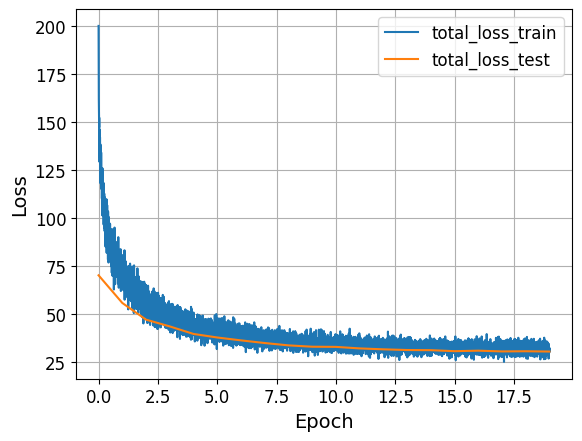

End of the training


In [ ]:
# ====
# your code
# choose these parameters
BATCH_SIZE = 128
LR = 2e-4
EPOCHS = 20
HIDDEN_CHANNELS = 64
CHANNEL_MULTIPLIERS = [1, 2]
NUM_BLOCKS = 2

sigma_max = 1.0
sigma_min = 0.01
L = 10
SIGMAS = list(np.geomspace(sigma_min, sigma_max, L))
# ====

train_loader = data.DataLoader(train_data, batch_size=BATCH_SIZE, shuffle=True)
test_loader = data.DataLoader(test_data, batch_size=BATCH_SIZE, shuffle=False)

ncsn = NoiseConditionedScoreNetwork(
    input_shape=(1, 14, 14), 
    sigmas=SIGMAS,
    hidden_channels=HIDDEN_CHANNELS,
    channel_multipliers=CHANNEL_MULTIPLIERS,
    num_blocks=NUM_BLOCKS
)

# choose any optimizer/scheduler as you want
optimizer = torch.optim.AdamW(ncsn.parameters(), lr=LR, betas=(0.9, 0.999), weight_decay=1e-3)
scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max=EPOCHS)

# train
train_model(
    ncsn,
    train_loader,
    test_loader,
    epochs=EPOCHS,
    optimizer=optimizer,
    scheduler=scheduler,
    device=DEVICE,
    n_samples=16,
    visualize_samples=False # probably you don't want to visualize samples, since it takes a lot of time
)

Now you can try to select proper inference parameters to obtain better images.

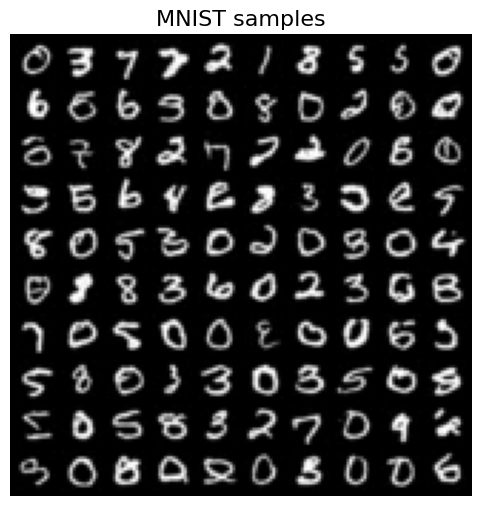

In [ ]:
# ====
# your code
# choose these parameters
NUM_STEPS = 100
EPS = 0.05
# ====

samples = ncsn.sample(100, num_steps=NUM_STEPS, eps=EPS).cpu()
show_samples(samples, "MNIST samples")